<!--NOTEBOOK_HEADER-->
*This notebook contains material from the [ND-Pyomo-Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/ND-Pyomo-Cookbook.git).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Scheduling with Disjunctive Constraints](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.00-Scheduling-with-Disjunctive-Constraints.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Job Shop Scheduling](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.02-Job-Shop-Scheduling.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.01-Machine-Bottleneck.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Machine Bottleneck

This notebook demonstrates the formulation and solution of the a machine bottleneck problem using Pyomo. The task is to schedule a set of jobs on a single machine given the release time, duration, and due time for each job. Date for the example problem is from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5, Dash Optimization, 2000.

## Imports

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *
from pyomo.gdp import *

## Example

The problem is to schedule a sequence of jobs for a single machine. The data consists of a Python dictionary of jobs. Each job is labeled by a key, and an associated data dictionary provides the time at which the job is released to the for machine processing, the expected duration of the job, and the due date. The problem is to sequence the jobs on the machine to meet the due dates, or show that no such sequence is possible.

In [22]:
JOBS = {
    'A': {'release': 2, 'duration': 5, 'due': 10},
    'B': {'release': 5, 'duration': 6, 'due': 21},
    'C': {'release': 4, 'duration': 8, 'due': 15},
    'D': {'release': 0, 'duration': 4, 'due': 10},
    'E': {'release': 0, 'duration': 2, 'due':  5},
    'F': {'release': 8, 'duration': 3, 'due': 15},
    'G': {'release': 9, 'duration': 2, 'due': 22},
}
JOBS

{'A': {'release': 2, 'duration': 5, 'due': 10},
 'B': {'release': 5, 'duration': 6, 'due': 21},
 'C': {'release': 4, 'duration': 8, 'due': 15},
 'D': {'release': 0, 'duration': 4, 'due': 10},
 'E': {'release': 0, 'duration': 2, 'due': 5},
 'F': {'release': 8, 'duration': 3, 'due': 15},
 'G': {'release': 9, 'duration': 2, 'due': 22}}

### Gantt chart

A traditional means of visualizing scheduling data in the form of a Gantt chart. The next cell presents a function `gantt` that plots a Gantt chart given JOBS and SCHEDULE information. Two charts are presented showing job schedule and machine schedule. If no machine information is contained in SCHEDULE, then it assumed to be a single machine operation.

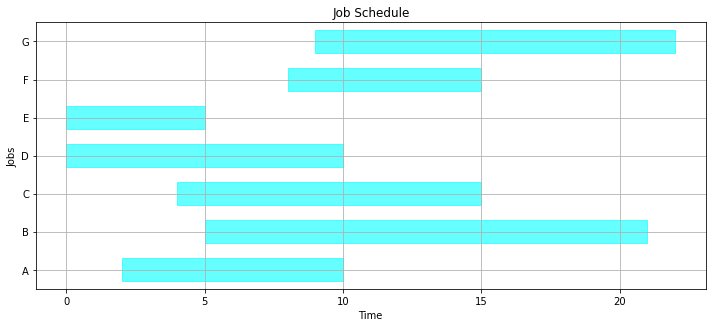

In [23]:
def gantt(JOBS, SCHEDULE={}):
    bw = 0.3
    plt.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    plt.ylim(-0.5, idx-0.5)
    plt.title('Job Schedule')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.yticks(range(len(JOBS)), JOBS.keys())
    plt.grid()
    xlim = plt.xlim()
    
    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        plt.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        plt.xlim(xlim)
        plt.ylim(-0.5, len(MACHINES)-0.5)
        plt.title('Machine Schedule')
        plt.yticks(range(len(MACHINES)), MACHINES)
        plt.ylabel('Machines')
        plt.grid()

gantt(JOBS)

## The machine scheduling problem

A schedule consists of a dictionary listing the start and finish times for each job. Once the order of jobs has been determined, the start time can be no earlier than when the job is released for processing, and no earlier than the finish of the previous job.

The following cell presents a function which, given the JOBS data and an order list of jobs indices, computes the start and finish times for all jobs on a single machine. We use this to determine the schedule if the jobs are executed in alphabetical order.

In [24]:
def schedule(JOBS, order=sorted(JOBS.keys())):
    """Schedule a dictionary of JOBS on a single machine in a specified order."""
    start = 0
    finish = 0
    SCHEDULE = {}
    for job in order:
        start = max(JOBS[job]['release'], finish)
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'start': start, 'finish': finish}
    return SCHEDULE   

SCHEDULE = schedule(JOBS)
SCHEDULE

{'A': {'start': 2, 'finish': 7},
 'B': {'start': 7, 'finish': 13},
 'C': {'start': 13, 'finish': 21},
 'D': {'start': 21, 'finish': 25},
 'E': {'start': 25, 'finish': 27},
 'F': {'start': 27, 'finish': 30},
 'G': {'start': 30, 'finish': 32}}

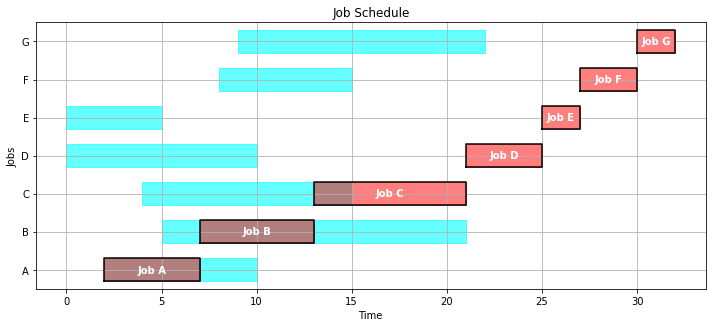

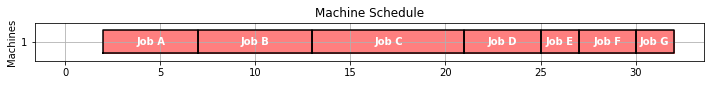

In [25]:
gantt(JOBS, SCHEDULE)

### Key performance indicators

As presented above, a given schedule may not meet all of the due time requirements. In fact, a schedule meeting all of the requirements might not even be possible. So given a schedule, it is useful to have a function that computes key performance indicators.

In [17]:
def kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

kpi(JOBS, SCHEDULE)

{'Makespan': 32,
 'Max Pastdue': 22,
 'Sum of Pastdue': 68,
 'Number Pastdue': 5,
 'Number on Time': 2,
 'Fraction on Time': 0.2857142857142857}

### Exercise

Show the Gantt chart and key performance metrics if the jobs are executed in reverse alphabetical order.

{'Makespan': 39,
 'Max Pastdue': 29,
 'Sum of Pastdue': 76,
 'Number Pastdue': 5,
 'Number on Time': 2,
 'Fraction on Time': 0.2857142857142857}

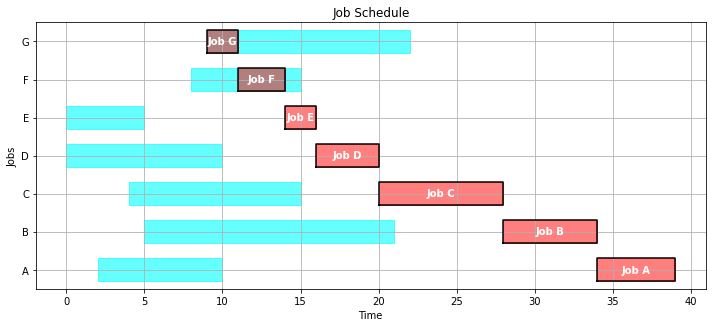

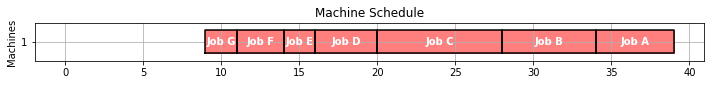

In [18]:
order = sorted(JOBS, reverse=True)
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

## Empirical scheduling

There are a number of commonly encountered empirical rules for scheduling jobs on a single machine. These include:

* First-In First-Out (FIFO)
* Last-In, First-Out (LIFO)
* Shortest Processing Time First (SPT)
* Earliest Due Data (EDD)

### First-in first-out

 As an example, we'll first look at 'First-In-First-Out' scheduling which executes job in the order they are released. The following function sorts jobs by release time, then schedules the jobs to execute in that order. A job can only be started no earlier than when it is released.

{'Makespan': 30,
 'Max Pastdue': 13,
 'Sum of Pastdue': 31,
 'Number Pastdue': 6,
 'Number on Time': 1,
 'Fraction on Time': 0.14285714285714285}

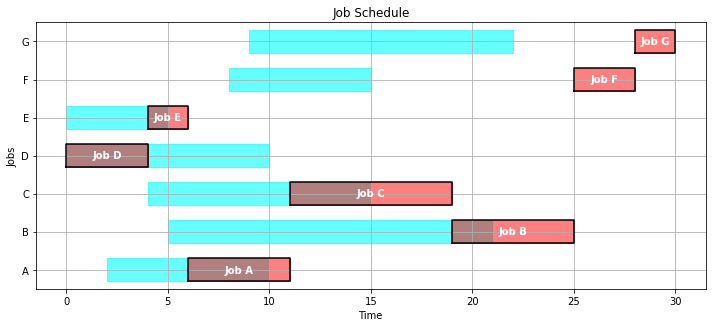

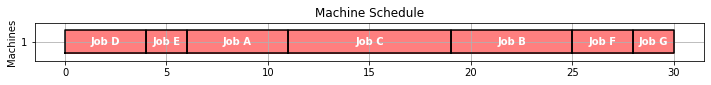

In [9]:
def fifo(JOBS):
    order_by_release = sorted(JOBS, key=lambda job: JOBS[job]['release'])
    return schedule(JOBS, order_by_release)

SCHEDULE = fifo(JOBS)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

### Last-in, first-out

{'Makespan': 30,
 'Max Pastdue': 20,
 'Sum of Pastdue': 34,
 'Number Pastdue': 3,
 'Number on Time': 4,
 'Fraction on Time': 0.5714285714285714}

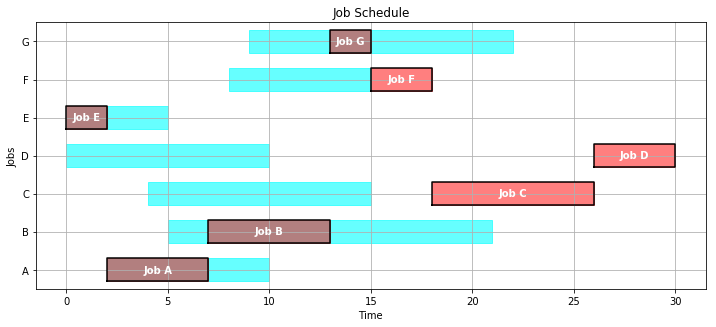

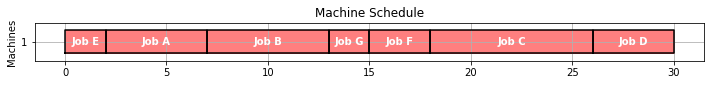

In [8]:
def lifo(JOBS):
    unfinished_jobs = set(JOBS.keys())
    start = 0
    while len(unfinished_jobs) > 0:
        start = max(start, min(JOBS[job]['release'] for job in unfinished_jobs))
        lifo = {job:JOBS[job]['release'] for job in unfinished_jobs if JOBS[job]['release'] <= start}
        job = max(lifo, key=lifo.get)
        finish = start + JOBS[job]['duration']
        unfinished_jobs.remove(job)
        SCHEDULE[job] = {'machine': 1, 'start': start, 'finish': finish}
        start = finish
    return SCHEDULE          
    
gantt(JOBS, lifo(JOBS))
kpi(JOBS, lifo(JOBS))

### Earliest due date

{'Makespan': 30,
 'Max Pastdue': 8,
 'Sum of Pastdue': 23,
 'Number Pastdue': 4,
 'Number on Time': 3,
 'Fraction on Time': 0.42857142857142855}

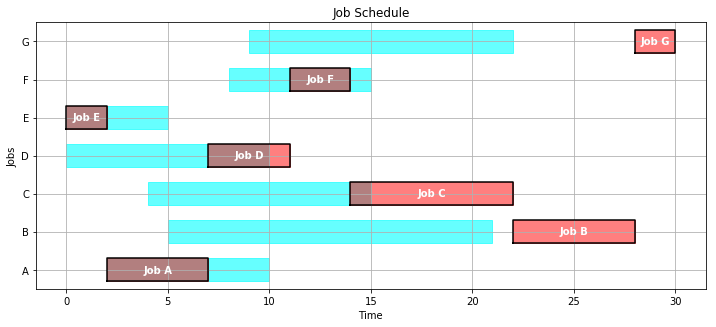

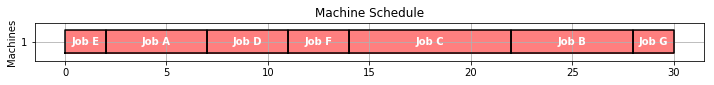

In [9]:
def edd(JOBS):
    unfinished_jobs = set(JOBS.keys())
    start = 0
    while len(unfinished_jobs) > 0:
        start = max(start, min(JOBS[job]['release'] for job in unfinished_jobs))
        edd = {job:JOBS[job]['due'] for job in unfinished_jobs if JOBS[job]['release'] <= start}
        job = min(edd, key=edd.get)
        finish = start + JOBS[job]['duration']
        unfinished_jobs.remove(job)
        SCHEDULE[job] = {'machine': 1, 'start': start, 'finish': finish}
        start = finish
    return SCHEDULE          
    
gantt(JOBS, edd(JOBS))
kpi(JOBS, edd(JOBS))

### Shortest processing time

{'Makespan': 30,
 'Max Pastdue': 15,
 'Sum of Pastdue': 18,
 'Number Pastdue': 4,
 'Number on Time': 3,
 'Fraction on Time': 0.42857142857142855}

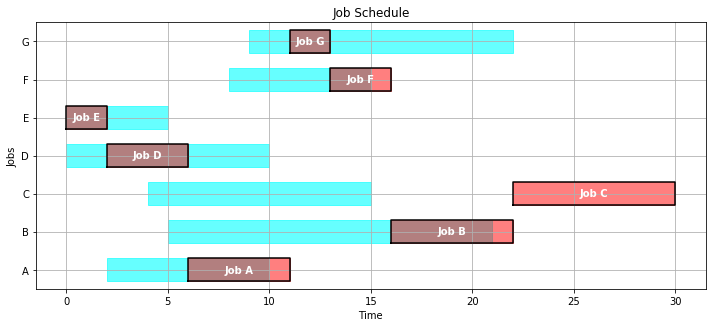

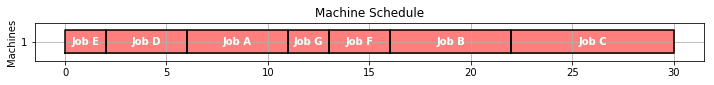

In [10]:
def spt(JOBS):
    unfinished_jobs = set(JOBS.keys())
    start = 0
    while len(unfinished_jobs) > 0:
        start = max(start, min(JOBS[job]['release'] for job in unfinished_jobs))
        spt = {job:JOBS[job]['duration'] for job in unfinished_jobs if JOBS[job]['release'] <= start}
        job = min(spt, key=spt.get)
        finish = start + JOBS[job]['duration']
        unfinished_jobs.remove(job)
        SCHEDULE[job] = {'machine': 1, 'start': start, 'finish': finish}
        start = finish
    return SCHEDULE          
    
gantt(JOBS, spt(JOBS))
kpi(JOBS, spt(JOBS))

## Modeling

### Data 

The data for this problem consists of a list of jobs. Each job is tagged with a unique ID along with numerical data giving the time at which the job will be released for machine processing, the expected duration, and the time at which it is due.

| Symbol | Description 
| ------ | :---------- 
| $\text{ID}_{j}$       | Unique ID for task $j$ 
| $\text{due}_{j}$      | Due time for task $j$ 
| $\text{duration}_{j}$ | Duration of task $j$ 
| $\text{release}_{j}$  | Time task $j$ becomes available for processing 

### Decision variables

For a single machine, the essential decision variable is the start time at which the job begins processing.

| Symbol | Description |
| ------ | :---------- |
| $\text{start}_{j}$ | Start of task $j$
| $\text{makespan}$ | Time to complete *all* jobs.
| $\text{pastdue}_{j}$ | Time by which task $j$ is past due
| $\text{early}_{j}$ | Time by which task $j$ is finished early

A job cannot start until it is released for processing
\begin{align*}
\text{start}_{j} & \geq \text{release}_{j}\\
\end{align*}

Once released for processing, we assume the processing continues until the job is finished. The finish time is compared to the due time, and the result stored in either the early or pastdue decision variables. These decision variables are needed to handle cases where it might not be possible to complete all jobs by the time they are due.

\begin{align*}
\text{start}_{j} + \text{duration}_{j} + \text{early}_{j} & = \text{due}_{j} + \text{pastdue}_{j}\\
\text{early}_{j} & \geq 0 \\
\text{pastdue}_{j} & \geq 0
\end{align*}

Finally, we include a single decision variable measuring the overall makespan for all jobs.
\begin{align*}
\text{start}_{j} +\text{duration}_{j} \leq \text{makespan}
\end{align*}

The final set of constraints requires that, for any given pair of jobs $j$ and $k$, that either $j$ starts before $k$ finishes, or $k$ finishes before $j$ starts. The boolean variable $y_{jk} = 1$ indicates $j$ finishes before $k$ starts, and is 0 for the opposing case. Note that we only need to consider cases $j > k$

\begin{align*}
\text{start}_{i}+\text{duration}_{i} & \leq \text{start}_{j}+My_{i,j}\\
\text{start}_{j}+\text{duration}_{j} & \leq \text{start}_{i}+M(1-y_{i,j})
\end{align*}

where $M$ is a sufficiently large enough to assure the relaxed constraint is satisfied for all plausible values of the decision variables.

## Pyomo model

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16.0
  Upper bound: 16.0
  Number of objectives: 1
  Number of constraints: 133
  Number of variables: 77
  Number of binary variables: 49
  Number of integer variables: 49
  Number of nonzeros: 7
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.55
  Wallclock time: 0.58
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

{'Makespan': 30.0,
 'Max Pastdue': 15.0,
 'Sum of Pastdue': 16.0,
 'Number Pastdue': 2,
 'Number on Time': 5,
 'Fraction on Time': 0.7142857142857143}

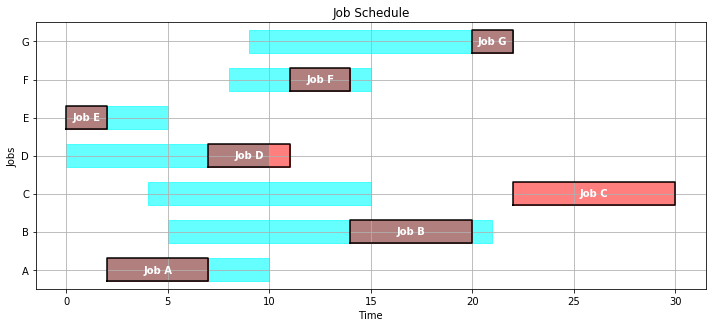

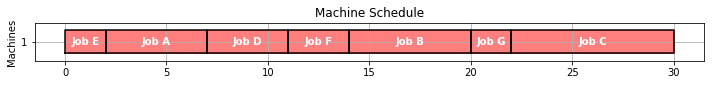

In [11]:
def opt_schedule(JOBS):

    # create model
    m = ConcreteModel()
    
    # index set to simplify notation
    m.J = Set(initialize=JOBS.keys())
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    # upper bounds on how long it would take to process all jobs
    tmax = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    # decision variables
    m.start      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
    m.pastdue    = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
    m.early      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
    
    # additional decision variables for use in the objecive
    m.makespan   = Var(domain=NonNegativeReals, bounds=(0, tmax))
    m.maxpastdue = Var(domain=NonNegativeReals, bounds=(0, tmax))
    m.ispastdue  = Var(m.J, domain=Binary)

    # objective function
    m.OBJ = Objective(expr = sum([m.pastdue[j] for j in m.J]), sense = minimize)

    # constraints
    m.c1 = Constraint(m.J, rule=lambda m, j: m.start[j] >= JOBS[j]['release'])
    m.c2 = Constraint(m.J, rule=lambda m, j: 
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
    m.c3 = Disjunction(m.PAIRS, rule=lambda m, j, k:
        [m.start[j] + JOBS[j]['duration'] <= m.start[k], 
         m.start[k] + JOBS[k]['duration'] <= m.start[j]])    
    
    m.c4 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= m.maxpastdue)
    m.c5 = Constraint(m.J, rule=lambda m, j: m.start[j] + JOBS[j]['duration'] <= m.makespan)
    m.c6 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= tmax*m.ispastdue[j])
    
    TransformationFactory('gdp.chull').apply_to(m)
    SolverFactory('cbc').solve(m).write()
    
    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {'machine': 1, 'start': m.start[j](), 'finish': m.start[j]() + JOBS[j]['duration']}
        
    return SCHEDULE

SCHEDULE = opt_schedule(JOBS)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

## Multiple machines

The case of multiple machines requires a modest extension of model described above. Given a set $M$ of machines, we introduce an additional decision binary variable $z_{j,m}$ indicating if job $j$ has been assigned to machine $m$. The additional constraints

\begin{align*}
\sum_{m\in M}z_{j,m} & = 1 & \forall j
\end{align*}

require each job to be assigned to exactly one machine for processing.  

If both jobs $j$ and $k$ have been assigned to machine $m$, then the disjunctive ordering constraints must apply.  This logic is equivalent to the following constraints for $j < k$.

\begin{align*}
\text{start}_{j}+\text{duration}_{j} & \leq \text{start}_{k}+My_{j,k} + M(1-z_{j,m}) + M(1-z_{k,m})\\
\text{start}_{k}+\text{duration}_{k} & \leq \text{start}_{j}+M(1-y_{j,k}) + M(1-z_{j,m}) + M(1-z_{k,m}))
\end{align*}

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -15.0
  Upper bound: -15.0
  Number of objectives: 1
  Number of constraints: 98
  Number of variables: 50
  Number of binary variables: 42
  Number of integer variables: 42
  Number of nonzeros: 15
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.42
  Wallclock time: 0.44
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound

{'Makespan': 15.0,
 'Max Pastdue': 0,
 'Sum of Pastdue': 0,
 'Number Pastdue': 0,
 'Number on Time': 7,
 'Fraction on Time': 1.0}

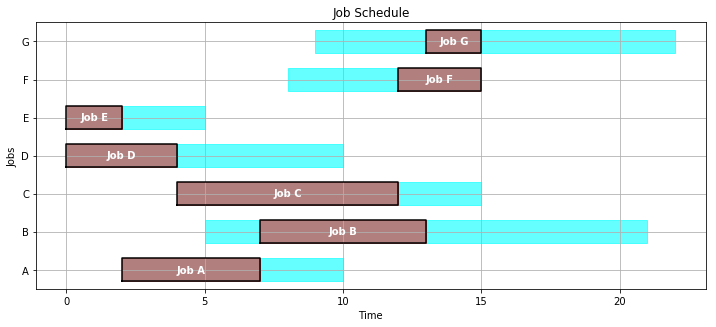

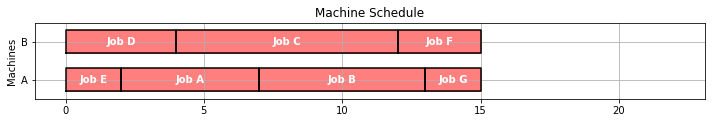

In [12]:
MACHINES = ['A','B']

def schedule_machines(JOBS, MACHINES):
    
    # create model
    m = ConcreteModel()
    
    # index set to simplify notation
    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    # decision variables
    m.start      = Var(m.J, bounds=(0, 1000))
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdue    = Var(m.J, domain=NonNegativeReals)
    m.early      = Var(m.J, domain=NonNegativeReals)
    
    # additional decision variables for use in the objecive
    m.ispastdue  = Var(m.J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)
    
    # for binary assignment of jobs to machines
    m.z = Var(m.J, m.M, domain=Binary)

    # for modeling disjunctive constraints
    m.y = Var(m.PAIRS, domain=Binary)
    BigM = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    m.OBJ = Objective(expr = sum(m.pastdue[j] for j in m.J) + m.makespan - sum(m.early[j] for j in m.J), sense = minimize)

    m.c1 = Constraint(m.J, rule=lambda m, j: 
            m.start[j] >= JOBS[j]['release'])
    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
    m.c3 = Constraint(m.J, rule=lambda m, j: 
            sum(m.z[j,mach] for mach in m.M) == 1)
    m.c4 = Constraint(m.J, rule=lambda m, j: 
            m.pastdue[j] <= BigM*m.ispastdue[j])
    m.c5 = Constraint(m.J, rule=lambda m, j: 
            m.pastdue[j] <= m.maxpastdue)
    m.c6 = Constraint(m.J, rule=lambda m, j: 
            m.start[j] + JOBS[j]['duration'] <= m.makespan)
    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM*(m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))
    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: 
            m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))
    
    SolverFactory('cbc').solve(m).write()
    
    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](), 
            'finish': m.start[j]() + JOBS[j]['duration'],
            'machine': [mach for mach in MACHINES if m.z[j,mach]][0]
        }
        
    return SCHEDULE
        
SCHEDULE = schedule_machines(JOBS,MACHINES)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

<!--NAVIGATION-->
< [Scheduling with Disjunctive Constraints](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.00-Scheduling-with-Disjunctive-Constraints.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Job Shop Scheduling](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.02-Job-Shop-Scheduling.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.01-Machine-Bottleneck.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>